#Importing the dataset from my google drive and converting it in numpy array.

In [ ]:
import h5py
import numpy as np
# loading ecg data
with h5py.File('/content/drive/My Drive/data/ecg_tracings.hdf5', "r") as f:
    x = np.array(f['tracings'])

#Shape of the numpy array, 827 patients, 12 lead sensors used to take readings, at 400Hz for 10 seconds.

In [ ]:
s=np.shape(x)
print(s)

(827, 4096, 12)


#Importing annotations(labels), labelled by three experiends Cardiologists and 2 other medical experts. 

In [ ]:
import pandas as pd
age_gender_attr= pd.read_csv('/content/drive/My Drive/data/attributes.csv')
# annotation
cardi_1= pd.read_csv('/content/drive/My Drive/data/annotations/cardiologist1.csv')

cardi_2= pd.read_csv('/content/drive/My Drive/data/annotations/cardiologist2.csv')

cardi_student4= pd.read_csv('/content/drive/My Drive/data/annotations/cardiology_residents.csv')

cardi_student3= pd.read_csv('/content/drive/My Drive/data/annotations/emergency_residents.csv')

cardi_gold= pd.read_csv('/content/drive/My Drive/data/annotations/gold_standard.csv')

cardi_student5= pd.read_csv('/content/drive/My Drive/data/annotations/medical_students.csv')

#Printing the shape of label's file. Annotations are given for six cardiac diseases if any, otherwise patient is considered as normal.

In [ ]:
s1= age_gender_attr.shape
s2= cardi_1.shape
s3= cardi_2.shape
s4= cardi_student4.shape
s5= cardi_student3.shape
s6= cardi_gold.shape
s7= cardi_student5.shape

print("age_gender_attr-  shape:  ", s1)
print("annotations by cardiologist1-  shape:  ",s2)
print("annotations by cardiologist2-  shape:  ",s3)
print("annotations by cardiology student 4th year-  shape:  ",s4)
print("annotations by cardiology student 3rd year-  shape:  ",s5)
print("annotations by experienced cardiologist-  shape:  ",s6)
print("annotations by cardiology student 5th year-  shape:  ",s7)

age_gender_attr-  shape:   (827, 2)
annotations by cardiologist1-  shape:   (827, 6)
annotations by cardiologist2-  shape:   (827, 6)
annotations by cardiology student 4th year-  shape:   (827, 6)
annotations by cardiology student 3rd year-  shape:   (827, 6)
annotations by experienced cardiologist-  shape:   (827, 6)
annotations by cardiology student 5th year-  shape:   (827, 6)


#Ploting the QRS complex(ECG signal), age and gender of a random patient. 

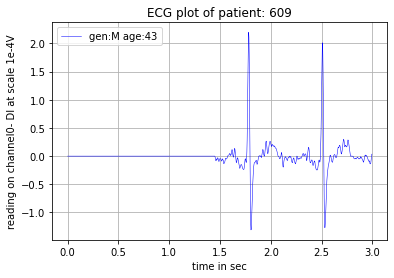

In [ ]:
import matplotlib.pyplot as plt
import random

patient_id= random.randrange(827)
p_age_gen=age_gender_attr.loc[patient_id]
ecg_r= x[patient_id][0:1200,0]
ecg_time= np.arange(0, 3, 0.0025)
plt.plot(ecg_time, ecg_r, linewidth=0.5, linestyle='solid', color='b')
plt.title('ECG plot of patient: '+str(patient_id))
plt.xlabel('time in sec')
plt.ylabel('reading on channel0- DI at scale 1e-4V')
plt.legend([str("gen:"+str(p_age_gen.sex)+" age:"+str(p_age_gen.age)),'channel:0'], loc = 0)
plt.grid(True)
plt.show()

# age and gender of patients

In [ ]:

age_gender_attr.head

<bound method NDFrame.head of      age sex
0     34   M
1     70   F
2     52   F
3     41   F
4     32   F
..   ...  ..
822   77   F
823   33   F
824   46   F
825   41   F
826   21   M

[827 rows x 2 columns]>

# x contains input data and y1, y2 and y_gold are labels annotated by three experienced Cardiologist, when y1 and y2 have a conflict
# then y_gold label will be taken

In [ ]:

y1= cardi_1.to_numpy()
y2= cardi_2.to_numpy()
y_gold= cardi_gold.to_numpy()

for i in range(y1.shape[0]):
    f1=0
    f2=0
    for j in range(6):
        if y1[i][j]==1 and f1==0:
            f1=1
        else:
            y1[i][j]=0
        if y2[i][j]==1 and f2==0:
            f2=1
        else:
            y2[i][j]=0

print(y1.shape)
print(y2.shape)
print(y_gold.shape)


(827, 6)
(827, 6)
(827, 6)


# Taking all three annotations by experienced Cardiologists into consideration and resolving the conflicts, if any, by giving the priority to the Gold standard as sudgested in documentation.

In [ ]:
y=[]

for i in range(y1.shape[0]):
  a= y1[i].argmax()
  b= y2[i].argmax()
  if a != b:
    y.append(y_gold[i][:])
  else:
    y.append(y1[i][:])

# adding one more column for normal patient, who does not have any abnormality
normal= []
y= np.array(y,dtype=object)
for i in range(y.shape[0]):
    t=np.sum(y[i])
    if t==0:
        normal.append([1])
    else:
        normal.append([0])

normal= np.array(normal)
y= np.append(y, normal, axis=1)
print(x.shape)
print(y.shape)

(827, 4096, 12)
(827, 7)


# Disease wise patient's count before resampling the data

In [ ]:

abnormalities = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST','normal']
print(abnormalities)
y_count= np.sum(y,axis=0)
print(y_count)

['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST', 'normal']
[29 31 27 14 10 32 684]


# Breaking the 10 sec data in 4 sec window (It will decrease complexity and increase examples.

In [ ]:

x_new=[]
y_new=[]
 
temp=663
for patient_id in range(827):
    if y[patient_id][6]==1 and temp>=0:  #skip reading for normal patients
        temp-=1
        continue
    for channel in range(12):
        s=0     #starting from 47 because 0-46 is padding bits
        
        for j in range(7):  # 5 samples from each patient's 10 sec reading
            p = np.zeros(1600, dtype = float)
            p = x[patient_id][s:s+1600,channel]
            x_new.append(p)
            y_new.append(y[patient_id][:])
            s=s+400
            

x_new= np.array(x_new,dtype=object)
y_new= np.array(y_new, dtype=object)
print(x_new.shape)
print(y_new.shape)

(13692, 1600)
(13692, 7)


# Disease wise patient's count, after resampling the data.

In [ ]:

print("after resampling the data")
abnormalities = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST','normal']
'''
1dAVb= 1st degree AV block
RBBB= Right bundle branch block
LBBB= Left bundle branch block
SB= Sinus Bradycardia
AF= Atrial Fibbrilation
ST= Sinus Tachycardia
normal= no abnormality 
'''
print(abnormalities)
y_count= np.sum(y_new,axis=0)
print(y_count)

after resampling the data
['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST', 'normal']
[2436 2604 2268 1176 840 2688 1680]


# changing the shape of label, by giving it's class value in range [0,6], [0:'1dAVb', 1:'RBBB', 2:'LBBB', 3:'SB', 4:'AF', 5:'ST',6:'normal']

In [ ]:

y= np.zeros(y_new.shape[0], dtype = float)
for i in range(y_new.shape[0]):
  y[i]= np.argmax(y_new[i][:])
y= np.array(y,dtype=object)

print(x_new.shape)
print(y.shape)

(13692, 1600)
(13692,)


# spliting the data in testing(20%) and training(80%) dataset

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10953, 1600)
(2739, 1600)
(10953,)
(2739,)


# Normalising the ECG readings, normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.

In [ ]:
  
import tensorflow as tf
# normalising the data values 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#print(X_train.mean(axis=0))
#print(X_train.std(axis=0))


# Reshaping the input to feed in CNN model. 

In [ ]:

print(X_train.shape)
print(X_test.shape)
X_train= np.reshape(X_train,(10953,1600,1))
X_test= np.reshape(X_test,(2739,1600,1))
y_train= np.reshape(y_train,(10953,1))
y_test= np.reshape(y_test,(2739,1))

y_train= np.asarray(y_train).astype(np.float64)
y_test= np.asarray(y_test).astype(np.float64)
print("dimensions after reshaping")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10953, 1600)
(2739, 1600)
dimensions after reshaping
(10953, 1600, 1)
(2739, 1600, 1)
(10953, 1)
(2739, 1)


# Defining the CNN model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Dropout
from numpy import unique

model = Sequential()
model.add(Conv1D(32, 16, activation="relu", input_shape=(1600,1)))
model.add(Conv1D(64, 16, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())

model.add(Conv1D(64, 32, activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPooling1D())

model.add(Conv1D(128, 32, activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

# Compiling the model 

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = "adam",               
              metrics = ['accuracy'])

#Printing the model summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1585, 32)          544       
                                                                 
 conv1d_9 (Conv1D)           (None, 1570, 64)          32832     
                                                                 
 dropout_10 (Dropout)        (None, 1570, 64)          0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 785, 64)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 754, 64)           131136    
                                                                 
 dropout_11 (Dropout)        (None, 754, 64)           0         
                                                      

#Defining a callback for early stopping, to avoid overfitting. 

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

# Training the model on ~11,000 inputs for 25 epochs.

In [ ]:
history=model.fit(X_train, y_train, batch_size=32,epochs=25, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/25
343/343 [==============================] - 16s 44ms/step - loss: 1.6225 - accuracy: 0.3576 - val_loss: 1.3164 - val_accuracy: 0.5440
Epoch 2/25
343/343 [==============================] - 15s 43ms/step - loss: 0.9736 - accuracy: 0.6431 - val_loss: 0.7729 - val_accuracy: 0.7747
Epoch 3/25
343/343 [==============================] - 14s 42ms/step - loss: 0.5711 - accuracy: 0.7991 - val_loss: 0.5340 - val_accuracy: 0.8361
Epoch 4/25
343/343 [==============================] - 14s 42ms/step - loss: 0.4032 - accuracy: 0.8659 - val_loss: 0.3302 - val_accuracy: 0.9237
Epoch 5/25
343/343 [==============================] - 14s 41ms/step - loss: 0.2698 - accuracy: 0.9085 - val_loss: 0.3629 - val_accuracy: 0.9252
Epoch 6/25
343/343 [==============================] - 14s 41ms/step - loss: 0.2293 - accuracy: 0.9249 - val_loss: 0.2437 - val_accuracy: 0.9478
Epoch 7/25
343/343 [==============================] - 15s 43ms/step - loss: 0.2111 - accuracy: 0.9347 - val_loss: 0.1681 - val_accuracy:

In [ ]:
print(history.history['accuracy'])

[0.35761892795562744, 0.6431114673614502, 0.799050509929657, 0.8658815026283264, 0.9085181951522827, 0.9248607754707336, 0.934721052646637, 0.9496941566467285, 0.9465899467468262, 0.946772575378418, 0.950972318649292, 0.9580023884773254, 0.9671322703361511, 0.9643020033836365, 0.9674062132835388, 0.9634803533554077, 0.9668583869934082, 0.9667670726776123, 0.9723363518714905, 0.9781795144081116, 0.9610152244567871, 0.9481420516967773, 0.9735232591629028, 0.9715146422386169]


# Printing test loss and test accuracy.

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print("test accuracy is: ",test_acc*100,"%")

86/86 - 1s - loss: 0.0960 - accuracy: 0.9741 - 851ms/epoch - 10ms/step
test accuracy is:  97.4078118801117 %


#Predicting the diseases for test data using  our trained model.

In [ ]:
y_pred = model.predict(X_test)

#Printing the F1-score, Precision and Recall of our model.
Precision: Precision quantifies the number of positive class predictions that actually belong to the positive class.             
Recall: Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pre_rec_F1= precision_recall_fscore_support(y_test, y_pred.argmax(axis=1), average='macro')
print("Precision, recall, f1-score: ",pre_rec_F1)

pre_rec_F1_= precision_recall_fscore_support(y_test, y_pred.argmax(axis=1), average='micro')
print("Precision, recall, f1-score: ",pre_rec_F1_)

Precision, recall, f1-score:  (0.9772597399014975, 0.9686818968850595, 0.9725933955888962, None)
Precision, recall, f1-score:  (0.9740781307046368, 0.9740781307046368, 0.9740781307046368, None)


# Defining our Confusion Matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)
cm= confusion_matrix(y_test, y_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,
                     index = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST','normal'], 
                     columns = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST','normal'])

#Plotting the confusion matrix

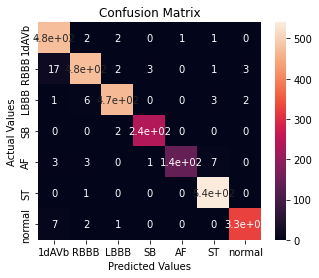

In [ ]:

import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#Saving our Model.

In [ ]:
model.save('/content/drive/My Drive/data/model_ecg5_gold')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/model_ecg5_gold/assets
